<a href="https://colab.research.google.com/github/Prasi21/Strep-Throat/blob/main/STREPCLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the inital scripts for working on the strep throat classification task. It contains train-val-test splitting, Data augmentation, Cycle-GAN augmentation, Grad-CAM, and basic model experiments. Comprehensive model training and benchmarking is found in the note book Strep_Benchmark.

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

## Import
import zipfile
from pathlib import Path
import os
import requests

import numpy as np
import os
#import shutilj_ecg_1.csv
import posixpath
import pandas as pd
import numpy as np
import ast


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Original Dataset zip files found here: https://data.mendeley.com/datasets/8ynyhnj2kz/2
os.chdir("/content/")
data_folder = Path('/content/nopharyngitis')
data_folder.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile('/content/drive/MyDrive/STREPDB/no pharyngitis.zip','r') as myzip:
  myzip.extractall(data_folder)


In [ ]:
os.chdir("/content/")
data_folder = Path('/content/pharyngitis')
data_folder.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile('/content/drive/MyDrive/STREPDB/pharyngitis.zip','r') as myzip:
  myzip.extractall(data_folder)

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms


In [ ]:
data_folder = Path('/content/Testfolder')
data_folder.mkdir(parents=True, exist_ok=True)



In [ ]:
data_folder = Path('/content/Testfolder/Class0')
data_folder.mkdir(parents=True, exist_ok=True)
data_folder = Path('/content/Testfolder/Class1')
data_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
data_folder = Path('/content/Valfolder')
data_folder.mkdir(parents=True, exist_ok=True)


data_folder = Path('/content/Valfolder/Class0')
data_folder.mkdir(parents=True, exist_ok=True)
data_folder = Path('/content/Valfolder/Class1')
data_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
def splitDataset(source, train_dir, val_dir, test_dir, train_ratio, val_ratio, test_ratio):
    files = os.listdir(source)
    random.shuffle(files)
    num_files = len(files)
    train_size = int(num_files * train_ratio)
    val_size = int(num_files * val_ratio)
    test_size = int(num_files * test_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size+val_size]
    test_files = files[train_size+val_size:]

    for file in train_files:
        shutil.copy(os.path.join(source, file), train_dir)

    for file in test_files:
        shutil.copy(os.path.join(source, file), test_dir)

    for file in val_files:
        shutil.copy(os.path.join(source, file), val_dir)



In [ ]:
# Split Pharyngitis and non-pharyngitis in a 80-10-10 split.
splitDataset('/content/nopharyngitis', '/content/Trainfolder/Class0', '/content/Valfolder/Class0', '/content/Testfolder/Class0', 0.8, 0.1, 0.1)
splitDataset('/content/pharyngitis', '/content/Trainfolder/Class1', '/content/Valfolder/Class1', '/content/Testfolder/Class1', 0.8, 0.1, 0.1)

In [ ]:
def Imageloader(inputpath,outputpath,start,max,verbose=0):
    count=0
    for dirname, _, filenames in os.walk(inputpath):
        for filename in filenames[start:max]:
            count=count+1
            if(verbose > 0):
                print(os.path.join(dirname, filename))
            image = Image.open(os.path.join(dirname, filename))
            transform = transforms.Compose([
                #transforms.PILToTensor(),
                transforms.Resize([224,224]),
                #transforms.functional.to_pil_image(image)
                ])
            image = transform(image)
            image.convert('RGB').save(f'{outputpath}/{count+start}.jpeg', format='jpeg')
            #torchvision.utils.save_image(tensor=image,fp=f'{outputpath}/{count}')
            if(verbose > 0):
                print(image)
    return count

In [ ]:
Imageloader('/content/nopharyngitis','/content/Valfolder/Class0',0,21)

21

In [ ]:
Imageloader('/content/nopharyngitis','/content/Testfolder/Class0',21,42)

21

In [ ]:
Imageloader('/content/pharyngitis','/content/Valfolder/Class1',0,34)

34

In [ ]:
Imageloader('/content/pharyngitis','/content/Testfolder/Class1',34,68)

34

In [ ]:
data_folder = Path('/content/Trainfolder')
data_folder.mkdir(parents=True, exist_ok=True)

data_folder = Path('/content/Trainfolder/Class0')
data_folder.mkdir(parents=True, exist_ok=True)
data_folder = Path('/content/Trainfolder/Class1')
data_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
Imageloader('/content/nopharyngitis','/content/Trainfolder/Class0',42,208)

166

In [ ]:
Imageloader('/content/pharyngitis','/content/Trainfolder/Class1',68,339)

79

# Data Augmentation

In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

# Directory containing the original images
original_dir = "/content/Trainfolder"

# Directory to save augmented images
save_dir_root = "/content/Augmented/Trainfolder"
os.makedirs(save_dir_root, exist_ok=True)

# Image augmentation parameters
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=10,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1])

# Function to apply augmentation and save images
def augment_images(load_dir, save_dir):
    for filename in os.listdir(load_dir):
        # print(filename)
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):  # Assuming images are in jpg or png format
            img_path = os.path.join(load_dir, filename)
            img = np.array(Image.open(img_path))  # Load image as numpy array
            img = img.reshape((1,) + img.shape)  # Add batch dimension

            # Generate augmented images
            augmented_images = []
            num_augmented_images = 10  # Number of augmented images per original image
            for i in range(num_augmented_images):
                augmented_img = datagen.flow(img).next()[0].astype(np.uint8)
                augmented_images.append(augmented_img)

            # Save augmented images
            base_filename = os.path.splitext(filename)[0]
            for i, augmented_img in enumerate(augmented_images):
                save_path = os.path.join(save_dir, f"{base_filename}_aug_{i}.jpg")
                Image.fromarray(augmented_img).save(save_path)


print("Augmenting Training Data")
# Recursively traverse through subdirectories and apply augmentation
for root, dirs, files in os.walk(original_dir):
    for class_dir in dirs:
        class_path = os.path.join(root, class_dir)
        save_class_dir = os.path.join(save_dir_root, class_dir)
        os.makedirs(save_class_dir, exist_ok=True)
        augment_images(class_path, save_class_dir)

print("Augmentation complete.")


original_dir = "/content/Valfolder"

# Directory to save augmented images
save_dir_root = "/content/Augmented/Valfolder"
os.makedirs(save_dir_root, exist_ok=True)

print("Augmenting Validation Data")
# Recursively traverse through subdirectories and apply augmentation
for root, dirs, files in os.walk(original_dir):
    for class_dir in dirs:
        class_path = os.path.join(root, class_dir)
        save_class_dir = os.path.join(save_dir_root, class_dir)
        os.makedirs(save_class_dir, exist_ok=True)
        augment_images(class_path, save_class_dir)

print("Augmentation complete.")



Augmenting Training Data
Augmentation complete.
Augmenting Validation Data
Augmentation complete.


In [ ]:
!cp -r /content/Augmented/ /content/drive/MyDrive/STREPDB/datasets/Augmented/

# CycleGAN

In [ ]:
# Follows the work done Jun Yan Zhu on CycleGAN augmentation
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
# Can be used to further increase the size of the strep throat dataset

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-nq5jbth_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-nq5jbth_
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=a8d1724b0e432e61eee1d121cacdddd17fb2d3bd6613b9caba4438c0e036cbac
  Stored in directory: /tmp/pip-ephem-wheel-cache-vvfk94ej/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import torchvision
from torchvision.transforms import ToTensor
from torchvision import utils

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
augTrainData = torchvision.datasets.ImageFolder(root= ("/content/Augmented/Trainfolder"), transform=ToTensor())
augTrainData_loader = torch.utils.data.DataLoader(augTrainData,
                                          batch_size=21,
                                          shuffle=True,)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Augmented/Trainfolder'

In [ ]:
augValdata = torchvision.datasets.ImageFolder(root= ("/content/Augmented/Valfolder"), transform=ToTensor())
augValdata_loader = torch.utils.data.DataLoader(augValdata,
                                          batch_size=21,
                                          shuffle=True,)

In [ ]:
single_batch = next(iter(augTrainData_loader))
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
# Tranformations to apply
# left and right flip, width and height translation from 5% to +5%, random rotation from 10° to 10°, zooming from 0% to 20%, and random brightness change from 10% to 10%.

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def resize(image):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  # image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = resize(image)
  image = normalize(image)
  return image

In [ ]:
# Optionally, you can map a function to read the image files into tensors
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Modify the channels if needed
    # Perform any preprocessing here if necessary
    return image

# Load images from folder
train_healthy_filenames = tf.constant([os.path.join("/content/Augmented/Trainfolder/Class0", name) for name in os.listdir("/content/Augmented/Trainfolder/Class0")])
train_healthy = tf.data.Dataset.from_tensor_slices(train_healthy_filenames).map(load_image)


# Load images from folder
test_healthy_filenames = tf.constant([os.path.join("/content/Augmented/Valfolder/Class0", name) for name in os.listdir("/content/Augmented/Valfolder/Class0")])
test_healthy = tf.data.Dataset.from_tensor_slices(test_healthy_filenames).map(load_image)

# Load images from folder
train_sick_filenames = tf.constant([os.path.join("/content/Augmented/Trainfolder/Class1", name) for name in os.listdir("/content/Augmented/Trainfolder/Class1")])
train_sick = tf.data.Dataset.from_tensor_slices(train_sick_filenames).map(load_image)

# Load images from folder
test_sick_filenames = tf.constant([os.path.join("/content/Augmented/Valfolder/Class1", name) for name in os.listdir("/content/Augmented/Valfolder/Class1")])
test_sick = tf.data.Dataset.from_tensor_slices(test_sick_filenames).map(load_image)



In [ ]:
train_healthy = train_healthy.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE)


train_sick = train_sick.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_healthy = test_healthy.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_sick = test_sick.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_healthy = next(iter(train_healthy))

In [ ]:
plt.subplot(121)
plt.title('Healthy')
plt.imshow(sample_healthy[0] * 0.5 + 0.5)

In [ ]:
sample_sick = next(iter(train_sick))
plt.subplot(121)
plt.title('Sick')
plt.imshow(sample_sick[0] * 0.5 + 0.5)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_sick = generator_g(sample_healthy)
to_healthy = generator_f(sample_sick)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_healthy, to_sick, sample_sick, to_healthy]
title = ['healthy', 'To sick', 'sick', 'To healthy']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real sick?')
plt.imshow(discriminator_y(sample_sick)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real healthy?')
plt.imshow(discriminator_x(sample_healthy)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5


def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# Each Checkpoint is approximately 1.3 Gb
checkpoint_path = "./checkpoints/train"
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

In [ ]:
EPOCHS = 80
START_EPOCH = 1
END_EPOCH = START_EPOCH+EPOCHS

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
generate_images(generator_g, sample_healthy)
generate_images(generator_f, sample_sick)

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
from tqdm import tqdm

for epoch in range(START_EPOCH,END_EPOCH):
  print(f"Epoch {epoch}/{END_EPOCH-1}")
  start = time.time()

  progress_bar = tqdm(tf.data.Dataset.zip((train_healthy, train_sick)))

  n = 0
  # for image_x, image_y in tf.data.Dataset.zip((train_healthy, train_sick)):
  for image_x, image_y in progress_bar:
    train_step(image_x, image_y)
    progress_bar.set_description(f'Epoch {epoch}/{END_EPOCH-1}')
    # if n % 10 == 0:
    #   print ('.', end='')
    # n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_healthy)
  generate_images(generator_f, sample_sick)

  if (epoch) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))

In [ ]:
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                      ckpt_save_path))


In [ ]:
!ls checkpoints -laR

In [ ]:
# !ls drive/MyDrive/STREPDB/Checkpoints/CycleGan
!cp checkpoints/train/ckpt-5.index drive/MyDrive/STREPDB/Checkpoints/CycleGan/ckpt-5.index

In [ ]:
print(type(test_healthy.take(1)))
inp = next(iter(test_healthy.range(5,10).take(2)))
generate_images(generator_g, inp)

In [ ]:
# Run the trained model on the test dataset
for inp in test_healthy.take(10):
    # inp = tf.image.resize(inp, (256, 256))
    generate_images(generator_g, inp)


In [ ]:
# Run the trained model on the test dataset
for inp in test_sick.take(10):
    inp = tf.image.resize(inp, (256, 256))
    generate_images(generator_f, inp)


In [ ]:
from google.colab import files

ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(END_EPOCH,
                                                      ckpt_save_path))
files.download(ckpt_save_path+".index")
files.download(ckpt_save_path+".data-00000-of-00001")

In [ ]:
# Extract every other image from the datasets
train_healthy_every_other = train_healthy.take(train_healthy.cardinality() // 2)
train_sick_every_other = train_sick.take(train_sick.cardinality() // 2)

# Verify the number of images in each dataset
num_train_healthy_every_other = sum(1 for _ in train_healthy_every_other)
num_train_sick_every_other = sum(1 for _ in train_sick_every_other)

print("Number of every other images in healthy class:", num_train_healthy_every_other)
print("Number of every other images in sick class:", num_train_sick_every_other)

In [ ]:
# save_dir_root = "/content/GAN_Augmented/Trainfolder"
save_dir_root = "/content/GAN_Augmented/Trainfolder/Class1"
os.makedirs(save_dir_root, exist_ok=True)

                # save_path = os.path.join(save_dir, f"{base_filename}_aug_{i}.jpg")
                # Image.fromarray(augmented_img).save(save_path)

for i, image_x in enumerate(train_healthy_every_other):
  fake_y = generator_g(image_x, training=False)
  save_path = os.path.join(save_dir_root, f"{i}.jpg")
  Image.fromarray(fake_y).save(save_path)


save_dir_root = "/content/GAN_Augmented/Trainfolder/Class0"
os.makedirs(save_dir_root, exist_ok=True)
for image_y in train_sick_every_other:
  fake_x = generator_f(image_y, training=False)
  save_path = os.path.join(save_dir_root, f"{i}.jpg")
  Image.fromarray(fake_x).save(save_path)



In [ ]:
!cp /content/GAN_Augmented/. /content/drive/MyDrive/STREPDB/GAN_Augmented

#Training set up

In [ ]:
import torchvision
from torchvision.transforms import ToTensor

In [ ]:
train_data = torchvision.datasets.ImageFolder(root= ("/content/Trainfolder"), transform=ToTensor())

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=21,
                                          shuffle=True,)

In [ ]:
testdata = torchvision.datasets.ImageFolder(root= ("/content/Testfolder"), transform=ToTensor())

In [ ]:
testdata_loader = torch.utils.data.DataLoader(testdata,
                                          batch_size=21,
                                          shuffle=True,)

In [ ]:
Valdata = torchvision.datasets.ImageFolder(root= ("/content/Valfolder"), transform=ToTensor())

In [ ]:
Valdata_loader = torch.utils.data.DataLoader(Valdata,
                                          batch_size=21,
                                          shuffle=True,)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob
from torch.optim.lr_scheduler import CyclicLR
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.display import display, clear_output
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def accuracy(outputs, labels, threshold=0.5):
    sigm = torch.sigmoid(outputs)
    predicted = (sigm > threshold).float()
    correct = (predicted == labels).float().sum()
    return (correct / labels.size(0)).item()

def plot_confusion_matrix(conf_mat, class_names):
    %matplotlib inline
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d",
                cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
dataiter = iter(train_data_loader)
X, labels = dataiter.__next__()
print(X.shape)
print(labels)


torch.Size([21, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])


In [ ]:


def train_and_evaluate(model_, train_loader, val_loader,test_loader, num_epochs, lr,threshold, weights=None):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    num_classes = 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model_(num_classes=num_classes).to(device)
    model.apply(initialize_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      running_corrects = 0
      total_samples = 0

      for i, (inputs, labels) in enumerate(train_loader):
          if torch.isnan(inputs).any():
              print(f"Found nan values in inputs at epoch {epoch+1}, iteration {i}. Skipping this batch.")
              continue


          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs).squeeze(1)

          loss = criterion(outputs, labels)
          print(f'outputs = {torch.log_softmax(outputs,dim =1)},')
          print(f'labels = {labels}')
          if torch.isnan(loss):
              print(f"Loss is nan at epoch {epoch+1}, iteration {i}. Exiting training.")
              break

          acc = binary_acc(outputs, labels)
          print(acc)
          loss.backward()
          optimizer.step()


          running_corrects += acc.item()
          running_loss += loss.item()
          print(loss.item())

      epoch_loss = running_loss / len(train_loader)
      epoch_acc = running_corrects / len(train_loader)
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_acc)

      model.eval()
      val_running_loss = 0.0
      val_running_corrects = 0
      val_total_samples = 0

      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs).squeeze(1)
          loss = criterion(outputs, labels)

          acc = binary_acc(outputs, labels)
          val_running_corrects += acc
          val_total_samples += labels.size(0)
          val_running_loss += loss.item()

      val_epoch_loss = val_running_loss / len(val_loader)
      val_epoch_acc = val_running_corrects / len(val_loader)
      print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc :.2f}%")

      val_losses.append(val_epoch_loss)
      val_accuracies.append(val_epoch_acc)


    test_corrects = 0
    test_total_samples = 0

    all_preds_list = []
    all_labels_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = model(inputs).squeeze(1)
            acc = binary_acc(outputs, labels)
            test_corrects += acc
            test_total_samples += labels.size(0)


            preds = torch.log_softmax(outputs,dim=1).cpu()
            _, preds = torch.max(preds, dim = 1)
            all_preds_list.append(preds)
            all_labels_list.append(labels.cpu().numpy())


    all_preds = np.concatenate(all_preds_list, axis=0)
    all_labels = np.concatenate(all_labels_list, axis=0)

    val_accuracies = [x.cpu().numpy() for x in val_accuracies]

    conf_mat = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(conf_mat, ['No pharyngitis', 'pharyngitis'])
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')

    plt.tight_layout()
    plt.show()
    return model

#Basic CNN 3-Layer

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import utils

In [ ]:
class ECG_CNN(nn.Module):
    def __init__(self, num_classes=1):
        super(ECG_CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )


        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )


        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)
        x=self.fc1(x)
        x = self.fc2(x)
        return x

    def layer_summary(self, X_shape,):
        X = torch.randn(*X_shape)
        for layer in self.conv1:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
        for layer in self.conv2:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
        for layer in self.conv3:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        print(self.fc1.__class__.__name__, 'output shape:\t', X.shape)





In [ ]:
128 * 56 * 56

401408

In [ ]:
def layer_summary(self, X_shape):
    transforms.Resize([224,224]),
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = ECG_CNN()
model.layer_summary((1, 3, 224, 224))

Conv2d output shape:	 torch.Size([1, 32, 224, 224])
BatchNorm2d output shape:	 torch.Size([1, 32, 224, 224])
ReLU output shape:	 torch.Size([1, 32, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 32, 112, 112])
Conv2d output shape:	 torch.Size([1, 64, 112, 112])
BatchNorm2d output shape:	 torch.Size([1, 64, 112, 112])
ReLU output shape:	 torch.Size([1, 64, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 64, 56, 56])
Conv2d output shape:	 torch.Size([1, 128, 56, 56])
BatchNorm2d output shape:	 torch.Size([1, 128, 56, 56])
ReLU output shape:	 torch.Size([1, 128, 56, 56])
Linear output shape:	 torch.Size([1, 256])


In [ ]:
single_batch = next(iter(train_data_loader))

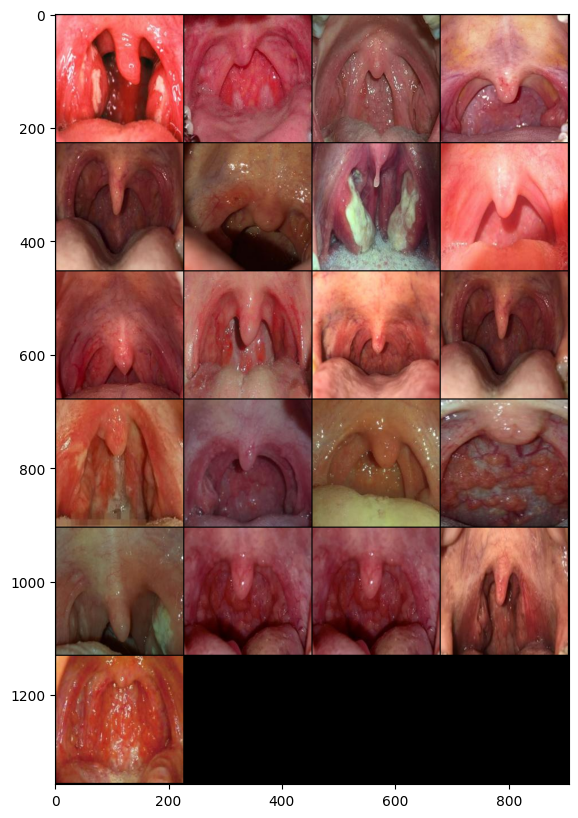

In [ ]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

Streaming output truncated to the last 5000 lines.
        [-2.2650e-06, -1.2994e+01],
        [-5.1402e-04, -7.5736e+00],
        [-3.5763e-07, -1.4921e+01]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>),
labels = tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
tensor(100., device='cuda:0')
0.00013827330258209258
outputs = tensor([[-4.2915e-06, -1.2347e+01],
        [-7.2717e-06, -1.1828e+01],
        [-7.0333e-06, -1.1860e+01],
        [ 0.0000e+00, -1.9836e+01],
        [-4.4433e+00, -1.1826e-02],
        [-2.8491e-05, -1.0465e+01],
        [-1.4664e+01, -4.7684e-07],
        [-2.2477e+01,  0.0000e+00],
        [-3.3961e+01,  0.0000e+00],
        [ 0.0000e+00, -1.6767e+01],
        [-1.6964e+01,  0.0000e+00],
        [ 0.0000e+00, -2.5294e+01],
        [-7.0881e-04, -7.2522e+00],
        [-4.5299e-06, -1.2309e+01],
        [-4.7684e-06, -1.2258e+01],
        [-5.9605e-07, -1.4344e+01],
        [-2.3842e-07, -1.5253e+01],
    

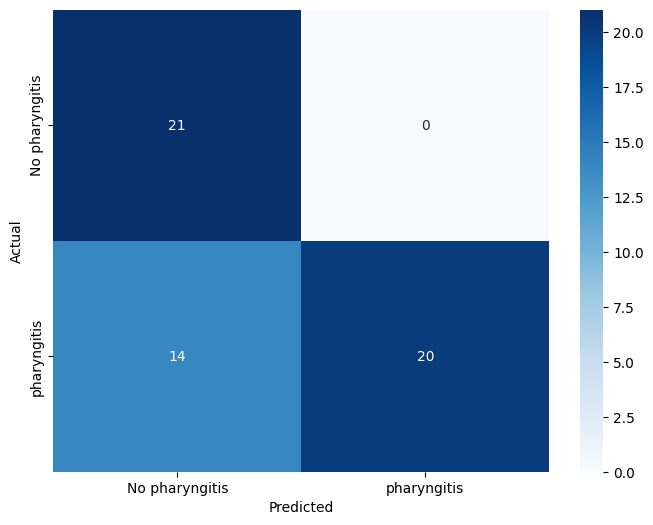

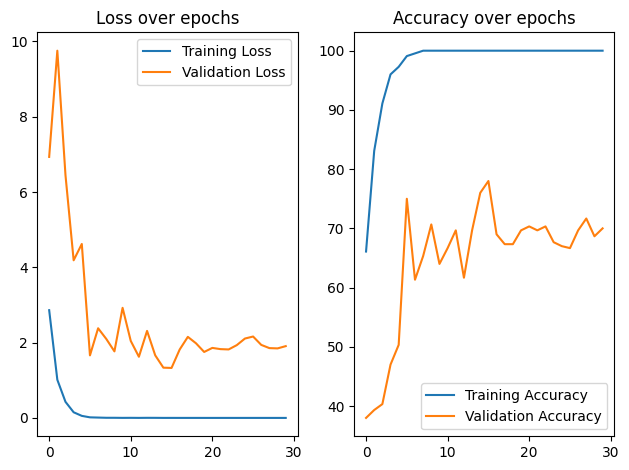

In [ ]:
CNN_model = train_and_evaluate(ECG_CNN, train_data_loader, Valdata_loader,testdata_loader, 30, 0.00001,0.5)

#Increased depth (leaky Relu) and skip connections

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = F.leaky_relu(out, negative_slope=0.01)
        return out

In [ ]:
class Deeper_Enhanced_ECG_CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(Deeper_Enhanced_ECG_CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

        self.res_block1 = ResidualBlock(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.res_block2 = ResidualBlock(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.res_block3 = ResidualBlock(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.res_block4 = ResidualBlock(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.res_block5 = ResidualBlock(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(1024, 2048)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 2)


    def convs(self, x):
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        return x

    def forward(self, x):
        x = self.convs(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        x = self.fc4(x)
        return x

In [ ]:
train_and_evaluate(Deeper_Enhanced_ECG_CNN, train_data_loader, Valdata_loader,testdata_loader, 40, 0.00001,0.5)

In [ ]:
train_and_evaluate(torchvision.models.vgg16, train_data_loader, Valdata_loader,testdata_loader, 40, 0.00001,0.5)


RuntimeError: Expected floating point type for target with class probabilities, got Long

# Pretrained ResNet50

In [ ]:
def concatenate_histories(history1, history2):
    concatenated_history = {}
    for key in history1.history.keys():
        concatenated_history[key] = history1.history[key] + history2.history[key]
    return concatenated_history


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet152
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import cv2


class ResNet(nn.Module):
  def __iniit__(self):
    super(ResNet, self).__init__()
    self.model = resnet152(pretrained=True)

    self.features = nn.Sequential(self.resnet.conv1,
                                  self.resnet.bn1,
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                                  self.resnet.layer1,
                                  self.resnet.layer2,
                                  self.resnet.layer3,
                                  self.resnet.layer4)

    self.avgpool = self.resnet.avgpool

    self.classifier = self.resnet.fc

    # Gradient placeholder
    self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad

    def get_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.features(x)

    def forward(self, x):

        # extract the features
        x = self.features(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)

        return x

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 20
LEARNING_RATE = 0.0001
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 2  # Healthy and not healthy
NUM_EPOCHS = 250

# Function to load and preprocess image
def load_and_preprocess_image(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]
    return img, label

# Load images and labels using tf.data.Dataset.list_files
train_dataset = tf.data.Dataset.list_files("/content/Augmented/Trainfolder/Class0/*.jpg")
train_dataset = train_dataset.map(lambda x: (x, 0))  # Label for healthy class is 0
train_dataset = train_dataset.concatenate(tf.data.Dataset.list_files("/content/Augmented/Trainfolder/Class1/*.jpg").map(lambda x: (x, 1)))  # Label for sick class is 1
train_dataset = train_dataset.map(load_and_preprocess_image)

val_dataset = tf.data.Dataset.list_files("/content/Augmented/Valfolder/Class0/*.jpg")
val_dataset = val_dataset.map(lambda x: (x, 0))  # Label for healthy class is 0
val_dataset = val_dataset.concatenate(tf.data.Dataset.list_files("/content/Augmented/Valfolder/Class1/*.jpg").map(lambda x: (x, 1)))  # Label for sick class is 1
val_dataset = val_dataset.map(load_and_preprocess_image)

test_dataset = tf.data.Dataset.list_files("/content/Testfolder/Class0/*.jpeg")
test_dataset = test_dataset.map(lambda x: (x, 0))  # Label for healthy class is 0
test_dataset = test_dataset.concatenate(tf.data.Dataset.list_files("/content/Testfolder/Class1/*.jpeg").map(lambda x: (x, 1)))  # Label for sick class is 1
test_dataset = test_dataset.map(load_and_preprocess_image)



# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
def finetune_pretrained(base_model):
    # Define learning rate schedule
    # def lr_schedule(epoch, lr):
    #     if epoch < 150:
    #         return lr
    #     elif epoch < 225:
    #         return lr * 0.1
    #     else:
    #         return lr * 0.01

    # # Create learning rate scheduler callback
    # lr_scheduler = LearningRateScheduler(lr_schedule)

    # Freeze base model layers
    base_model.trainable = False


    # Add new classification layers
    x = GlobalAveragePooling2D()(base_model.output)
    # x = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001),)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=output)

    # Optionally, unfreeze some layers of the convolutional base for fine-tuning
    for layer in model.layers[:15]:
        layer.trainable = True


    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks = [
        reduce_lr,
        early_stopping,]


    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=callbacks, verbose=1)

    # Save the model
    # model.save("resnet50_model.h5")
    return history, model


In [ ]:
# Create base model using pre-trained ResNet50 without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
history, resnet_model = finetune_pretrained(base_model)



# Save the model
# model.save("resnet50_model.h5")


Epoch 1/250
123/123 [==============================] - 11s 63ms/step - loss: 0.5997 - accuracy: 0.6776 - val_loss: 0.7100 - val_accuracy: 0.3818 - lr: 1.0000e-04
Epoch 2/250
123/123 [==============================] - 7s 54ms/step - loss: 0.6813 - accuracy: 0.6776 - val_loss: 0.7438 - val_accuracy: 0.3818 - lr: 1.0000e-04
Epoch 3/250
123/123 [==============================] - 7s 55ms/step - loss: 0.6587 - accuracy: 0.6776 - val_loss: 0.7679 - val_accuracy: 0.3818 - lr: 1.0000e-04
Epoch 4/250
123/123 [==============================] - 7s 55ms/step - loss: 0.6498 - accuracy: 0.6776 - val_loss: 0.7836 - val_accuracy: 0.3818 - lr: 1.0000e-04
Epoch 5/250
123/123 [==============================] - 7s 56ms/step - loss: 0.6452 - accuracy: 0.6776 - val_loss: 0.7952 - val_accuracy: 0.3818 - lr: 1.0000e-04
Epoch 6/250
123/123 [==============================] - 7s 56ms/step - loss: 0.6429 - accuracy: 0.6776 - val_loss: 0.7995 - val_accuracy: 0.3818 - lr: 1.0000e-04
Epoch 7/250
123/123 [============

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
history_inception, inception_model = finetune_pretrained(base_model)


In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
history_vgg, vgg_model = finetune_pretrained(base_model)


In [ ]:

# Define learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 150:
        return lr
    elif epoch < 225:
        return lr * 0.95
    else:
        return lr * 0.1

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks=[lr_scheduler]

history2 = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, initial_epoch=61, callbacks=callbacks, verbose=1)

In [ ]:
resnet_model = model

In [ ]:
history = concatenate_histories(history, history2)

In [ ]:
history = history_vgg

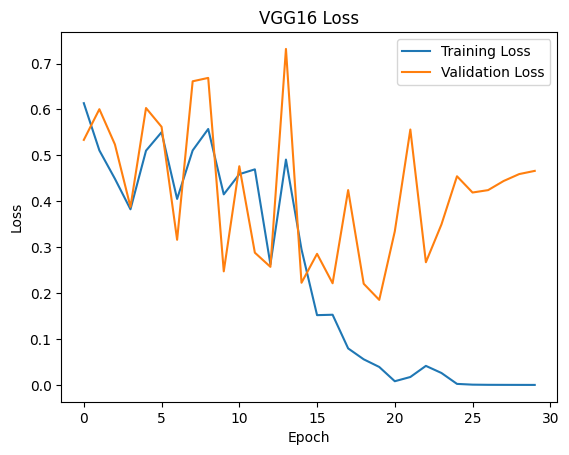

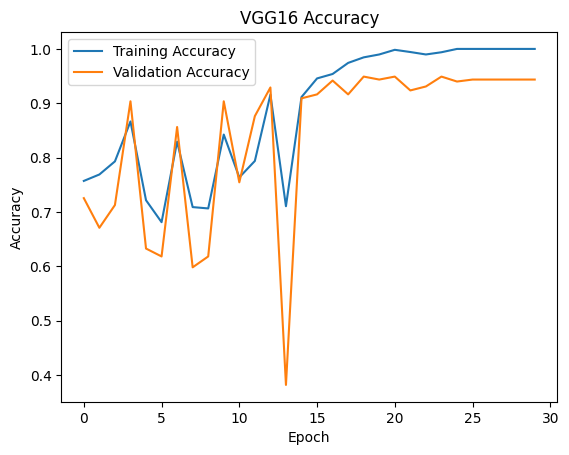

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model = vgg_model

In [ ]:
# Loss, Accuracy
model.evaluate(val_dataset)

28/28 [==============================] - 2s 78ms/step - loss: 0.4663 - accuracy: 0.9436


[0.46627575159072876, 0.9436363577842712]

In [ ]:
# Loss, Accuracy
model.evaluate(test_dataset)

3/3 [==============================] - 3s 1s/step - loss: 0.3249 - accuracy: 0.9636


[0.32486382126808167, 0.9636363387107849]

In [ ]:
resnet_model.save("resnet.keras")

In [ ]:
inception_model.save("inception.keras")

In [ ]:
vgg_model.save("vgg.keras")

In [ ]:
import coatnet


ModuleNotFoundError: No module named 'coatnet'

In [ ]:
import coatnet

coatnet_model = coatnet.coatnet0(input_shape = (32, 32, 3), include_top = False)

flatten = tf.keras.layers.GlobalAveragePooling2D()(coatnet_model.output)
drop_out = tf.keras.layers.Dropout(0.5)(flatten)
dense = tf.keras.layers.Dense(2048, activation = "relu")(drop_out)
prediction = tf.keras.layers.Dense(10, activation = "softmax", name = "prediction")(dense)
coatnet_model = tf.keras.Model(coatnet_model.input, prediction)


## Grad-CAM

In [ ]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5249 sha256=17b7183530c7b8ad7286f439e5580505733e38d133c57168c8d5917c7f2fd721
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [ ]:
import os

# os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0  

In [ ]:
# last_conv_layer_name = "conv5_block3_out"
# last_conv_layer_name = "conv2d_93"
last_conv_layer_name = "block5_conv2"



1/1 [==============================] - 0s 34ms/step
[[0.00026947]]


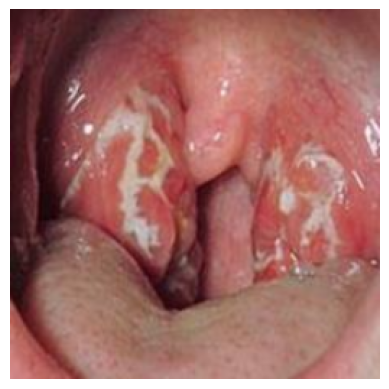

In [ ]:
# img_path = "/content/Valfolder/Class1/28.jpeg"
img_path = "/content/drive/MyDrive/STREPDB/Testfolder/Class1/65.jpeg"
img, label = load_and_preprocess_image(img_path, 0)
img_np = tf.expand_dims(img, axis=0)
pred = model.predict(image_np)
print(pred)
plt.imshow(img)
plt.axis('off')
plt.show()


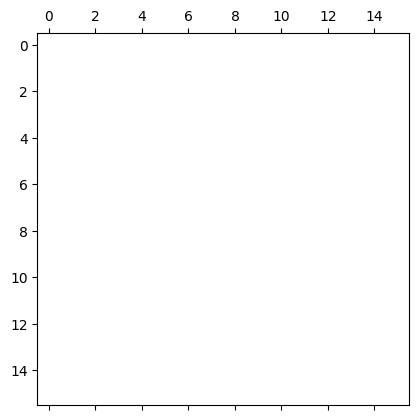

In [ ]:
# # Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Make model
# model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# model.layers[-1].activation = None

# Print what the top predicted class is
# preds = model.predict(val_dataset.take(1))
# print("Predicted:", )

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_np, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


<ipython-input-196-17c17e96b054>:9: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


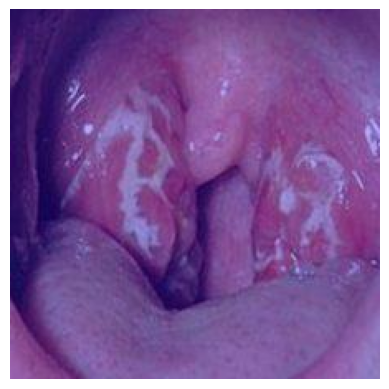

In [ ]:
from IPython.display import display
import matplotlib.image as mpimg
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(mpimg.imread(cam_path))
    plt.axis('off')
    plt.box(False)
    plt.show()
    # display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import torch
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Convert TensorFlow model to PyTorch model
def convert_to_torch(model):
    model_torch = Model(model.input, model.output)
    return model_torch

# Load the saved model
# model = tf.keras.models.load_model("resnet50_model.h5")

# Convert to PyTorch model
model_torch = convert_to_torch(model)

# Load an image for generating saliency map
image_path = "/content/Trainfolder/Class0/110.jpeg"
image = Image.open(image_path)
image = image.resize((224, 224))  # Resize image to match model input size
image_tensor = transforms.ToTensor()(image).unsqueeze(0)

# Initialize GradCAM
target_layer = model_torch.get_layer(index=-1)  # Get the last layer
gradcam = GradCAM(model_torch, target_layer)

# Generate CAM
cam = gradcam.generate_cam(image_tensor)

# Convert the CAM to PIL image
cam_image = show_cam_on_image(image, cam.numpy())

# Display or save the CAM image
cam_image.show()
# cam_image.save("saliency_map.jpg")


ModuleNotFoundError: No module named 'pytorch_grad_cam'

# Pytorch Models - Migrated to Strep Benchmark Notebook

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import time

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Define constants
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 2  # Healthy and not healthy
NUM_EPOCHS = 25
BATCH_SIZE = 20
LEARNING_RATE = 0.0001

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load images and labels using ImageFolder
train_dataset = ImageFolder(root="/content/drive/MyDrive/STREPDB/datasets/Augmented/Trainfolder/", transform=data_transforms)
val_dataset = ImageFolder(root="/content/drive/MyDrive/STREPDB/datasets/Augmented/Valfolder/", transform=data_transforms)
test_dataset = ImageFolder(root="/content/drive/MyDrive/STREPDB/datasets/Original/Testfolder/", transform=data_transforms)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using device: cpu


In [ ]:
timestp = time.strftime("%Y%m%d-%H%M%S")

# New classifier must already be added
def finetune_pretrained(base_model, out_dir=f"model-{timestp}.pt"):
    # Freeze base model layers
    for param in base_model.features.parameters():
        param.requires_grad = False

    # Move model to device
    base_model = base_model.to(device)

    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(base_model.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(NUM_EPOCHS):
        base_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = base_model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}")


    # Optionally, unfreeze some layers of the convolutional base for fine-tuning
    for param in base_model.features.parameters():
        param.requires_grad = True

    # Redefine optimizer for fine-tuning
    optimizer = optim.Adam(base_model.parameters(), lr=0.0001)


    # Fine-tuning loop
    for epoch in range(NUM_EPOCHS):
        base_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = base_model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}")




    # Evaluate the model
    base_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = base_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy: {100 * correct / total:.2f}%")

    # Save the model
    torch.save(base_model.state_dict(), out_dir)



In [ ]:
model = base_model

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_recall_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Assuming you have your model, test loader, and device (cuda/cpu) set up
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probabilities.cpu().numpy())


In [ ]:

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = (y_scores >= 0.5).astype(int)

# Metrics without confidence intervals
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
f1 = f1_score(y_true, y_pred)
# F2 Score
beta = 2
f2 = fbeta_score(y_test, y_pred, beta=beta)
print(f'F2 Score: {f2:.4f}')
auc = roc_auc_score(y_true, y_scores)

# Function to compute metrics
def compute_metrics(y_true, y_pred, y_scores, threshold=0.5):
    y_pred = (y_scores >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    f1 = f1_score(y_true, y_pred)
    beta = 2
    f2 = fbeta_score(y_true, y_pred, beta=beta)
    auc = roc_auc_score(y_true, y_scores)
    return acc, cm, fpr, fnr, f1, f2, auc

# Bootstrapping for 95% Confidence Intervals
n_iterations = 1000
conf_intervals = {
    'accuracy': [],
    'fpr': [],
    'fnr': [],
    'f1': [],
    'f2': [],
    'auc': []
}

for i in range(n_iterations):
    indices = np.random.choice(len(y_true), len(y_true), replace=True)
    y_true_bootstrap = y_true[indices]
    y_scores_bootstrap = y_scores[indices]
    metrics = compute_metrics(y_true_bootstrap, (y_scores_bootstrap >= 0.5).astype(int), y_scores_bootstrap)
    for metric, value in zip(conf_intervals.keys(), metrics):
        conf_intervals[metric].append(value)

for metric, values in conf_intervals.items():
    ci_lower = np.percentile(values, 2.5)
    ci_upper = np.percentile(values, 97.5)
    print(f"{metric}: 95% CI [{ci_lower:.3f}, {ci_upper:.3f}]")

# Threshold Analysis for FPR and FNR
thresholds = np.arange(0.0, 1.0, 0.01)
fpr_list = []
fnr_list = []

for threshold in thresholds:
    _, _, fpr, fnr, _, _, _ = compute_metrics(y_true, (y_scores >= threshold).astype(int), y_scores, threshold)
    fpr_list.append(fpr)
    fnr_list.append(fnr)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, fpr_list, label='False Positive Rate')
plt.plot(thresholds, fnr_list, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FPR and FNR vs. Threshold')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: not enough values to unpack (expected 4, got 0)

In [ ]:
total = 0
_, predicted = torch.max(outputs, 1)
total += labels.size(0)
correct += (predicted == labels).sum().item()


NameError: name 'correct' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'y_test' is not defined

In [ ]:
timestp = time.strftime("%Y%m%d-%H%M%S")

# Load the pretrained model
base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
num_ftrs = base_model.classifier[0].in_features

print(base_model)

base_model.classifier = nn.Sequential(
    nn.Linear(in_features=num_ftrs, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1),
    nn.Sigmoid()
)
print(base_model)

# Modify the model

# print(models.resnet50(weights=models.ResNet50_Weights.DEFAULT))
# # Add new classification layers
# num_ftrs = base_model.fc.in_features
# base_model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 1),
#     nn.Sigmoid()
# )


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
finetune_pretrained(base_model)


KeyboardInterrupt: 

# Model Profiling

In [ ]:
import gc

del model
gc.collect()


112607

In [ ]:
import time
import numpy as np
import os
import psutil
from tensorflow.keras.models import load_model

model_path = 'vgg.keras'

model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert bytes to megabytes
print(f"Model size: {model_size:.2f} MB")

# Function to measure memory usage
def memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Convert bytes to megabytes

# Measure memory usage before loading the model
initial_memory = memory_usage()

# Load the model
model = load_model(model_path)

# Measure memory usage after loading the model
loaded_memory = memory_usage()

# Prepare a sample input (adjust the shape to match your model's input shape)
input_shape = (1, 256, 256, 3)  # Example input shape for an image model
sample_input = np.random.random(input_shape).astype(np.float32)

# Warm-up runs
for _ in range(10):
    _ = model.predict(sample_input, verbose=0)

# Measure inference time
start_time = time.time()
_ = model.predict(sample_input, verbose=0)
end_time = time.time()
inference_time = end_time - start_time

# Measure memory usage during inference
inference_memory = memory_usage()

print(f"Inference time: {inference_time:.6f} seconds")
print(f"Initial memory usage: {initial_memory:.2f} MB")
print(f"Memory usage after loading model: {loaded_memory:.2f} MB")
print(f"Memory usage during inference: {inference_memory:.2f} MB")

Model size: 114.48 MB
Inference time: 0.062832 seconds
Initial memory usage: 4903.37 MB
Memory usage after loading model: 4889.65 MB
Memory usage during inference: 4889.59 MB


In [ ]:
from google.colab import runtime
runtime.unassign()